In [79]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [80]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [81]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

In [97]:
csv_path = tf.keras.utils.get_file(
    # origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-hourly_timeseries_filled.csv.tar.gz')
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-land_timeseries_filled.csv.zip')
csv_path

'C:\\Users\\ASUS\\.keras\\datasets\\era5-land_timeseries_filled.csv.zip'

In [98]:
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)
df.head(5)

,Unnamed: 0,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
0,2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
date_col = 'datetime' 
df = df.rename(columns={df.columns[0]: date_col})

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])
    
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 33576


,datetime,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
0,2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
print(df[date_col].dt.year.unique())
print(df[date_col].dt.year.value_counts())

[2021 2022 2023 2024 2025]
datetime
2022    8808
2024    8784
2023    8784
2025    7177
2021      23
Name: count, dtype: int64


In [101]:
df.shape

(33576, 13)

In [102]:
# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(33576, 12)


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
datetime,,,,,,,,,,,,
2021-12-31 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-31 05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [103]:
# Ensure index has no duplicates before reindexing
dup_cnt = df.index.duplicated().sum()
if dup_cnt:
  print(f"Found {dup_cnt} duplicate timestamps; keeping first occurrence")
  df = df[~df.index.duplicated(keep='first')]
  print(df.shape)

Found 96 duplicate timestamps; keeping first occurrence
(33480, 12)


In [104]:
# Upsample from hourly to 15-minute resolution
# Create 15-minute index spanning the full range
start = df.index.min()
end = df.index.max()
freq_15min = pd.date_range(start=start, end=end, freq='15min')
freq_15min

DatetimeIndex(['2021-12-31 01:00:00', '2021-12-31 01:15:00',
               '2021-12-31 01:30:00', '2021-12-31 01:45:00',
               '2021-12-31 02:00:00', '2021-12-31 02:15:00',
               '2021-12-31 02:30:00', '2021-12-31 02:45:00',
               '2021-12-31 03:00:00', '2021-12-31 03:15:00',
               ...
               '2025-10-25 21:45:00', '2025-10-25 22:00:00',
               '2025-10-25 22:15:00', '2025-10-25 22:30:00',
               '2025-10-25 22:45:00', '2025-10-25 23:00:00',
               '2025-10-25 23:15:00', '2025-10-25 23:30:00',
               '2025-10-25 23:45:00', '2025-10-26 00:00:00'],
              dtype='datetime64[ns]', length=133917, freq='15min')

In [105]:
# Ensure index is sorted (monotonic) for reindex with ffill
if not df.index.is_monotonic_increasing:
  print("Sorting index to ensure monotonic order")
  df = df.sort_index()

In [106]:
# Reindex and forward-fill (each hour's values replicate to all 4 quarters)
#df_15min = df.reindex(freq_15min, method='ffill')

# Reindex เพื่อสร้างแถวว่างสำหรับช่วงเวลา 15 นาที
df_15min = df.reindex(freq_15min)

# ทำ Cubic Spline Interpolation
# เราต้องระบุ method='cubic' เพื่อใช้เส้นโค้งกำลังสาม
df_15min = df_15min.interpolate(method='cubic')

# หมายเหตุ: สำหรับข้อมูลขอบสุดที่อาจหาค่าไม่ได้ (NaN) 
# อาจต้องใช้ bfill() หรือ ffill() ปิดท้ายเล็กน้อย
df_15min = df_15min.bfill().ffill()

print(f"Original hourly rows: {len(df)}")
print(f"Upsampled 15-min rows: {len(df_15min)}")
df_15min.head(8)  # Show first 2 hours = 8 x 15min rows

Original hourly rows: 33480
Upsampled 15-min rows: 133917


,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
2021-12-31 01:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-12-31 01:15:00,1.175864e-10,6.071940e-14,-0.000002,0.000006,-0.000003,-9.100054e-07,0.000008,0.000016,-2.316478e-13,-4.182899e-13,3.916236e-08,2.815411e-17
2021-12-31 01:30:00,1.343845e-10,6.939360e-14,-0.000003,0.000007,-0.000003,-1.040006e-06,0.000009,0.000018,-2.647404e-13,-4.780456e-13,4.475698e-08,3.217612e-17
2021-12-31 01:45:00,8.399031e-11,4.337100e-14,-0.000002,0.000005,-0.000002,-6.500039e-07,0.000005,0.000011,-1.654627e-13,-2.987785e-13,2.797312e-08,2.011008e-17
2021-12-31 02:00:00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-12-31 02:15:00,-8.399031e-11,-4.337100e-14,0.000002,-0.000005,0.000002,6.500039e-07,-0.000005,-0.000011,1.654627e-13,2.987785e-13,-2.797312e-08,-2.011008e-17
2021-12-31 02:30:00,-1.343845e-10,-6.939360e-14,0.000003,-0.000007,0.000003,1.040006e-06,-0.000009,-0.000018,2.647404e-13,4.780456e-13,-4.475698e-08,-3.217612e-17
2021-12-31 02:45:00,-1.175864e-10,-6.071940e-14,0.000002,-0.000006,0.000003,9.100054e-07,-0.000008,-0.000016,2.316478e-13,4.182899e-13,-3.916236e-08,-2.815411e-17


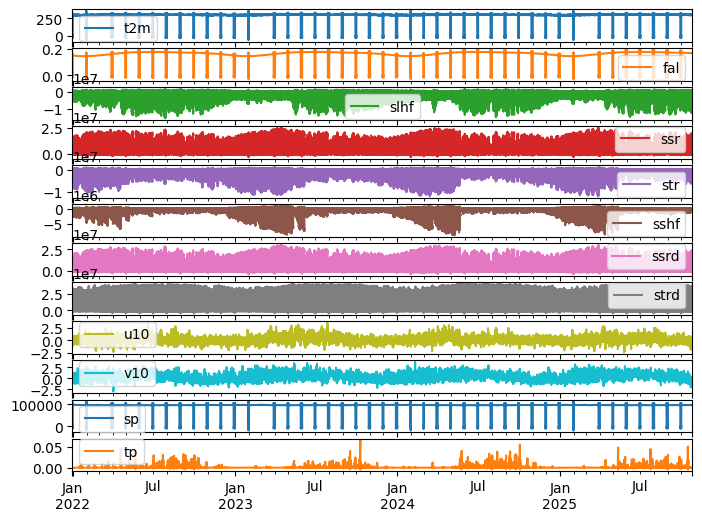

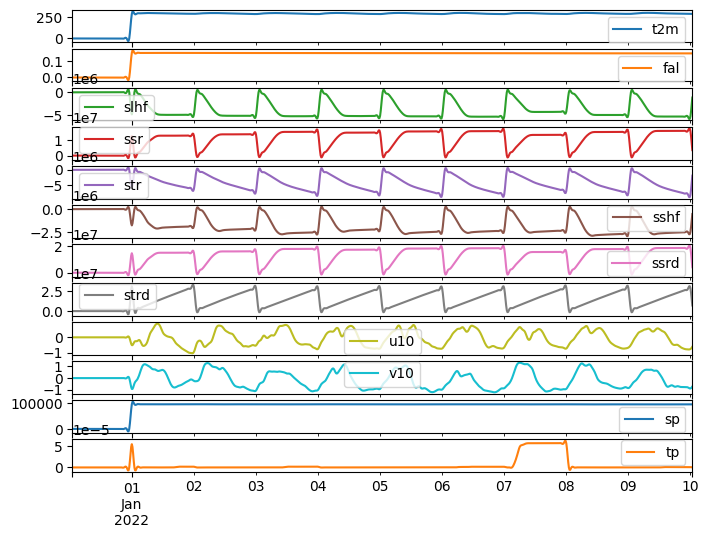

In [107]:
display_all(df_15min)

In [108]:
df_15min.index.name = 'datetime'
df_15min

,t2m,fal,slhf,ssr,str,sshf,ssrd,strd,u10,v10,sp,tp
datetime,,,,,,,,,,,,
2021-12-31 01:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-12-31 01:15:00,1.175864e-10,6.071940e-14,-2.455112e-06,6.456325e-06,-3.032223e-06,-9.100054e-07,7.591848e-06,1.591653e-05,-2.316478e-13,-4.182899e-13,3.916236e-08,2.815411e-17
2021-12-31 01:30:00,1.343845e-10,6.939360e-14,-2.805842e-06,7.378657e-06,-3.465398e-06,-1.040006e-06,8.676397e-06,1.819032e-05,-2.647404e-13,-4.780456e-13,4.475698e-08,3.217612e-17
2021-12-31 01:45:00,8.399031e-11,4.337100e-14,-1.753651e-06,4.611661e-06,-2.165874e-06,-6.500039e-07,5.422748e-06,1.136895e-05,-1.654627e-13,-2.987785e-13,2.797312e-08,2.011008e-17
2021-12-31 02:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-25 23:00:00,2.938509e+02,1.674507e-01,-7.245413e+06,1.214595e+07,-4.216508e+06,-9.478656e+05,1.458819e+07,3.220765e+07,-1.724998e-01,-1.083124e+00,9.610883e+04,1.001149e-03
2025-10-25 23:15:00,2.939783e+02,1.674507e-01,-7.477966e+06,1.253687e+07,-4.355223e+06,-9.409952e+05,1.505778e+07,3.253375e+07,-1.900778e-01,-1.005082e+00,9.608022e+04,9.003007e-04
2025-10-25 23:30:00,2.942238e+02,1.674507e-01,-7.891013e+06,1.322931e+07,-4.578262e+06,-9.298197e+05,1.588956e+07,3.284787e+07,-2.075996e-01,-8.803937e-01,9.601993e+04,7.216707e-04


In [109]:
filename = Path(csv_path).name
base = re.split(r'\.', filename, maxsplit=1)[0]
print(base)

era5-land_timeseries_filled


In [110]:
# Compressed CSV
save_path = 'C:\\Users\\ASUS\\.keras\\datasets\\' + base + '_15min.csv'
df_15min.to_csv(save_path)